# DeepSets / PointNet
Deep neural network trained on *permutation invariant* geometric data from reflexive 3D lattice polyhedra. We use encoder-decoder architecture inspired by https://proceedings.neurips.cc/paper_files/paper/2017/file/f22e4747da1aa27e363d86d40ff442fe-Paper.pdf and input / feature alignment as in
https://openaccess.thecvf.com/content_cvpr_2017/papers/Qi_PointNet_Deep_Learning_CVPR_2017_paper.pdf

In [1]:
import pandas as pd
import numpy as np
from ast import literal_eval
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam
from keras.utils import plot_model, to_categorical
from keras.models import Model
from keras.callbacks import EarlyStopping
import keras.layers as L
import keras.backend as K
from keras_tuner import HyperParameters, RandomSearch
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
%load_ext blackcellmagic
NUM_CLASSES = 20 # to_categorical maps to 0,...,NUM_CLASSES-1
MIN_VERTICES, MAX_VERTICES = 4, 14
input_shape = (3, MAX_VERTICES)

2023-07-07 09:23:08.839016: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# Data

def aug(df, n=1):
    """ Augment by n random permutations of columns of df["pad"] """
    res = []
    for _, row in df.iterrows():
        mat, pic = row["pad"], row["pic"]
        perm_list = []
        for _ in range(n):
            perm_mat = mat[:, np.random.permutation(MAX_VERTICES)]
            perm_list.append((mat, pic, perm_mat))    
        perm_df = pd.DataFrame(perm_list, columns=["matrix", "pic", "pad"])
        res.append(perm_df)
    return pd.concat(res, ignore_index=True)

def prep_data(df):
    X, y = df["pad"], df["pic"]
    X, y = np.stack(X), to_categorical(y, num_classes=NUM_CLASSES)
    X = np.transpose(X, axes=[0,2,1])
    return X, y

df = pd.read_csv("../data/Pic4319.csv", converters={"matrix":lambda s: np.array(literal_eval(s))}, header=None, names=["matrix", "pic"])
df["pad"] = df["matrix"].apply(lambda mat: np.pad(mat, ((0, 0), (0, MAX_VERTICES - mat.shape[1]))))
X, y = prep_data(df)

In [6]:
UNITS = [0, 32, 64, 128]
LR = [1e-3, 5e-3, 1e-2, 5e-1]
DROPOUT = [0.0, 0.1, 0.2]


class PlotLearning(keras.callbacks.Callback):
    """Callback to plot the learning curves of the model during training."""

    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]

        # Plotting
        metrics = [x for x in logs if "val" not in x]
        f, axs = plt.subplots(1, len(metrics), figsize=(15, 5))
        clear_output(wait=True)
        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), self.metrics[metric], label=metric)
            if logs["val_" + metric]:
                axs[i].plot(
                    range(1, epoch + 2),
                    self.metrics["val_" + metric],
                    label="val_" + metric,
                )
            axs[i].legend()
            axs[i].grid()
        plt.tight_layout()
        plt.show()


def width_acc(y_true, y_pred, width=1):
    diff = K.abs(K.argmax(y_pred, axis=-1) - K.argmax(y_true, axis=-1))
    res = tf.math.count_nonzero(K.less_equal(diff, width))
    return int(res) / int(tf.shape(y_pred)[0])


def plot_confusion(model, X_test, y_test):
    y_true = np.argmax(y_test, axis=1)
    y_pred = np.argmax(model.predict(X_test), axis=1)
    conf_mat = confusion_matrix(y_true, y_pred, labels=range(1, NUM_CLASSES))
    disp = ConfusionMatrixDisplay(conf_mat, display_labels=range(1, NUM_CLASSES))
    fig, ax = plt.subplots(figsize=(10,10)) 
    disp.plot(ax=ax, colorbar=False)
    plt.show()
    
# PointNet

class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=1e-3):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

def hp_tnet(hp, inputs, num_features, name=""):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    orth_reg = OrthogonalRegularizer(num_features)
    x = inputs
    
    for i in range(hp.Int(name+"conv", 1, 6)):
        filters = hp.Choice(name+f"filters_{i}", values=UNITS)
        x = L.Conv1D(filters, kernel_size=1, padding="valid", activation="relu")(x) if filters else x
        # x = L.BatchNormalization(momentum=0.0)(x) if hp.Boolean(name+f"batchn_{i}") else x
        
    x = L.Dropout(hp.Choice(name+"conv_dropout", values=DROPOUT))(x)
        
    x = L.GlobalMaxPooling1D()(x)
    
    for i in range(hp.Int(name+"dense", 1, 4)):
        units = hp.Choice(f"units{i}", values=UNITS)
        x = L.Dense(units, activation="relu")(x)
        
    x = L.Dropout(hp.Choice(name+"dense_dropout", values=DROPOUT))(x)
        
    x = L.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=orth_reg,
    )(x)
    feat_T = L.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return L.Dot(axes=(2, 1))([inputs, feat_T])

    
def hp_deepset_model(hp):
    lr = hp.Choice("lr", values=LR)
    decay = 1e-4
    optimizer = Adam(learning_rate=lr, decay=decay)
    metrics = ["accuracy", width_acc]
    
    inputs = L.Input(shape=(MAX_VERTICES, 3))
    x = L.Masking(mask_value=0, input_shape=(MAX_VERTICES, 3))(inputs)
    
    # Input Alignment
    x = tnet(hp, x, 3, name="input_tnet")
    
    # Encoder
    for i in range(hp.Int("encoder", 1, 4)):
        filters = hp.Choice(f"encoder_units{i}", values=UNITS)
        x = L.Conv1D(filters, kernel_size=1, activation="relu")(x) if filters else x
    
    # Feature Alignment
    x = tnet(hp, x, x.shape[-1], name="feature_tnet")
    
    # Pooling
    x_avg = L.GlobalAveragePooling1D(data_format="channels_last", name="avg")(x)
    x_max = L.GlobalMaxPooling1D(data_format="channels_last", name="max")(x)
    x = L.Concatenate(name="pooling", axis=1)([x_avg, x_max])
    
    # Decoder
    for i in range(hp.Int("decoder", 1, 4)):
        units = hp.Choice(f"decoder_units{i}", values=UNITS)
        x = L.Dense(units, activation="relu")(x) if units else x
    
    # Classifier
    # x = L.Flatten()(x)
    outputs = L.Dense(NUM_CLASSES, activation="softmax")(x)

    # Model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=metrics)
    print(model.summary())
    return model

def train_model(model, data, batch_size=32, epochs=500, patience=30):
    X_train, X_test, y_train, y_test = data
    callbacks_list = [
        PlotLearning(),
        EarlyStopping(monitor="val_accuracy", patience=patience, verbose=1),
    ]
    hist = model.fit(
        X_train,
        y_train,
        validation_data=(X_test, y_test),
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
        shuffle=True,
        callbacks=callbacks_list,
    )

    return model, hist.history

# plot_model(model, show_shapes=True, show_layer_names=False)
# plot_confusion(model, X_test, y_test)
L1_REG = keras.regularizers.L1(l1=1e-3)
def tnet(inputs, num_features, name=""):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    orth_reg = OrthogonalRegularizer(num_features)
    x = inputs
    x = L.Conv1D(32, kernel_size=1, padding="valid", activation="relu")(x)
    x = L.Conv1D(32, kernel_size=1, padding="valid", activation="relu")(x)
    
    x = L.GlobalMaxPooling1D()(x)
    x = L.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=orth_reg,
    )(x)
    feat_T = L.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return L.Dot(axes=(2, 1))([inputs, feat_T])

def deepset_model(lr=1e-3, decay=1e-4):
    optimizer = Adam(learning_rate=lr, decay=decay)    
    metrics = ["accuracy", width_acc]
    
    inputs = L.Input(shape=(MAX_VERTICES, 3))
    x = inputs
    # x = L.Masking(mask_value=0, input_shape=(MAX_VERTICES, 3))(inputs)
    
    # Input Alignment
    x = tnet(x, 3, name="input_tnet")
    
    # Encoder
    x = L.Conv1D(16, kernel_size=1, activation="relu", name="encoder")(x)
    
    # Feature Alignment
    # x = tnet(x, x.shape[-1], name="feature_tnet")
    
    # Pooling
    x = x_avg = L.GlobalAveragePooling1D(data_format="channels_last", name="avg")(x)
    # x = x_max = L.GlobalMaxPooling1D(data_format="channels_last", name="max")(x)
    # x = L.Concatenate(name="pooling", axis=1)([x_avg, x_max])
    
    # Decoder
    # x = L.Dense(32, activation="relu")(x)
    x = L.Dense(32, activation="relu", name="decoder")(x)
    
    # Classifier
    outputs = L.Dense(NUM_CLASSES, activation="softmax")(x)

    # Model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=metrics)
    print(model.summary())
    return model

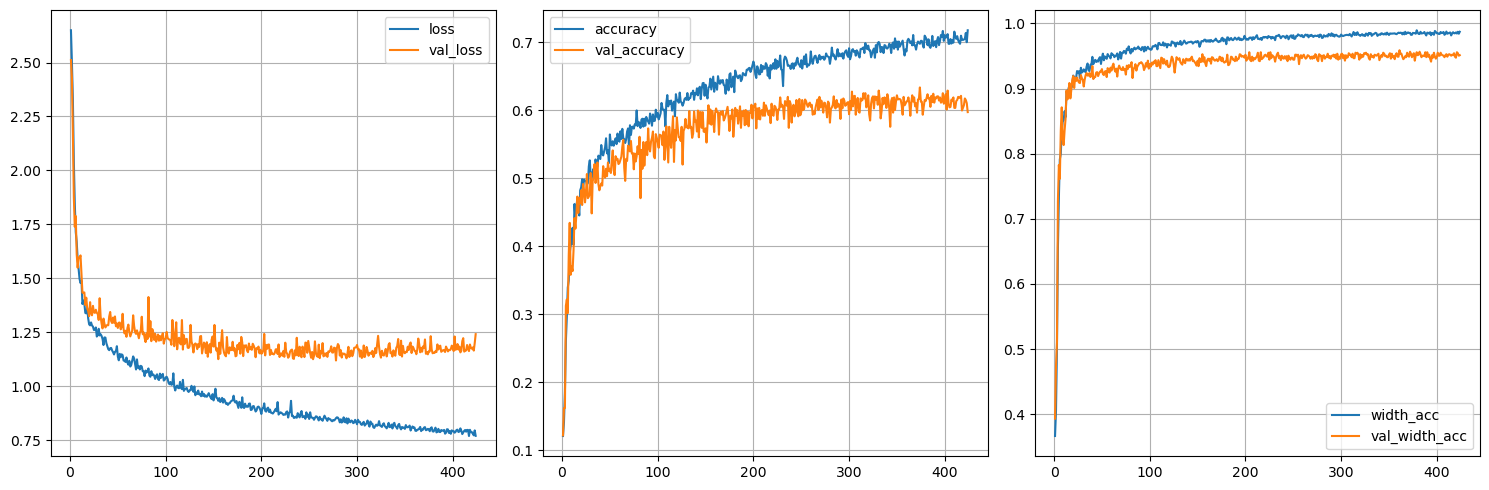

95/95 [==============================] - 1s 6ms/step - loss: 0.7709 - accuracy: 0.7175 - width_acc: 0.9872 - val_loss: 1.2419 - val_accuracy: 0.5972 - val_width_acc: 0.9512
Epoch 425/2000
91/95 [===========================>..] - ETA: 0s - loss: 0.7887 - accuracy: 0.7047 - width_acc: 0.9856

KeyboardInterrupt: 

In [7]:
data = X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=None)
model = deepset_model(lr=5e-3, decay=1e-4)
model, history = train_model(model, data, batch_size=32, epochs=2000, patience=100)

41/41 [==============================] - 0s 941us/step


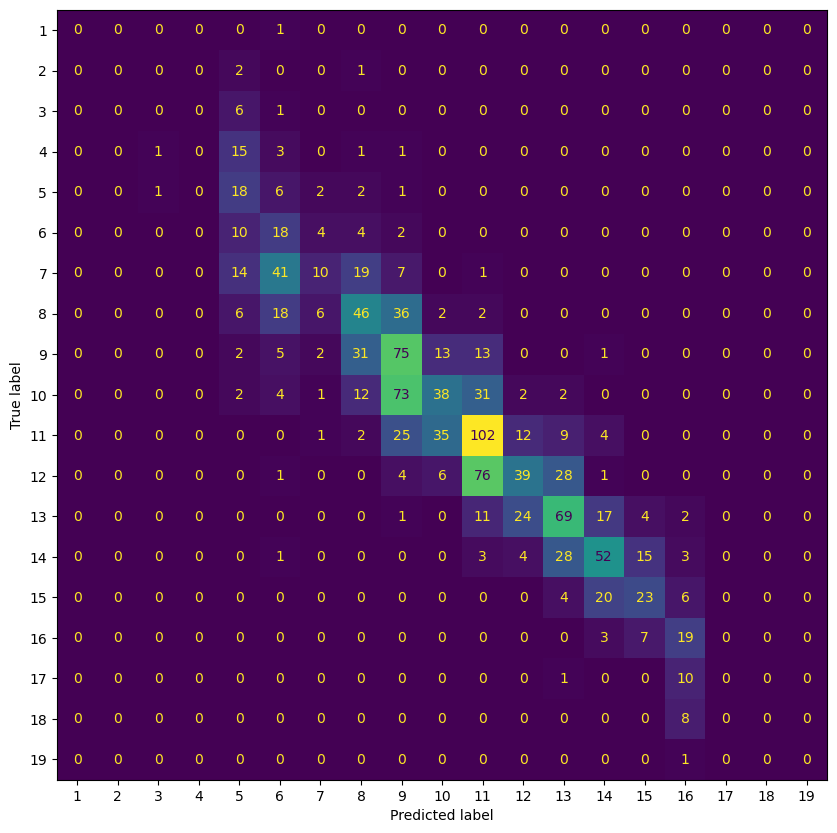

In [945]:
plot_confusion(model, X_test, y_test)

In [ ]:
tuner = RandomSearch(
    hypermodel=hp_deepset_model,
    objective="val_accuracy",
    max_trials=40,
    executions_per_trial=1,
    overwrite=True,
    directory="hp"
)
tuner.search(X_train,
        y_train,
        validation_data=(X_test, y_test),
        batch_size=32,
        epochs=500,
        verbose=1,
        shuffle=True,
        callbacks=[EarlyStopping(monitor="val_loss", patience=20, verbose=1)])

<Axes: >

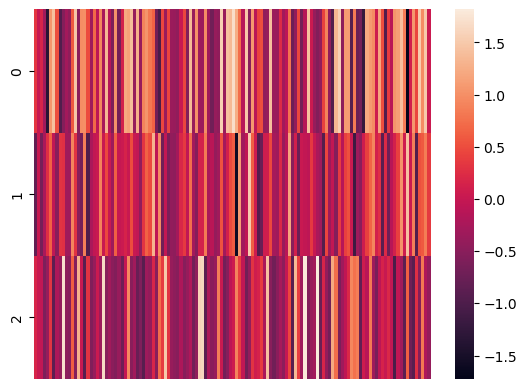

In [916]:
weights = model.get_layer("encoder").get_weights()[0]
sns.heatmap(np.squeeze(weights),xticklabels=False, yticklabels=True)